# ERASTAR : Colocalisation d'observations avec le datacube

Dans les parties précédentes nous avons construit et testé le datacube. Ici, nous allons réaliser des tests de colocalisation entre le datacube et les points d'observations. Pour chaque point d'observations, nous allons extraire un petit cube et enregistrer les résultats dans des fichiers NetCDF.

In [1]:
import os
import dask
import intake
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask_jobqueue
import dask.distributed

from pathlib import Path

## Cluster Dask

In [2]:
# Création du cluster Dask
cluster = dask_jobqueue.PBSCluster(queue='omp', 
                                   cores=28,
                                   memory="300GB", # Essayer avec 500GB
                                   walltime="01:00:00",
                                   interface='ib0',
                                   local_directory='/tmp',
                                   log_directory='/home1/scratch/gcaer/dask-logs',
                                   #processes=4,
                                  )
cluster.scale(jobs=2)

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58840 instead
  warnings.warn(


In [3]:
client = dask.distributed.Client(cluster, timeout=600)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.34:58840/status,
Dashboard: http://10.148.0.34:58840/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.34:33431,Workers: 0
Dashboard: http://10.148.0.34:58840/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
port = client.scheduler_info()["services"]["dashboard"]
ssh_command = f'ssh -N -L {port}:{os.environ["HOSTNAME"]}:{port} {os.environ["USER"]}@datarmor.ifremer.fr'

print(f"{ssh_command}")
print(f"open browser at address of the type: http://localhost:{port}")

ssh -N -L 58840:r1i0n33:58840 gcaer@datarmor.ifremer.fr
open browser at address of the type: http://localhost:58840


## Ouverture des datacubes

In [5]:
# Chemin vers le datacube
wrk = Path('/home/datawork-data-terra/odatis/data')
name = 'erastar'
version = 'datacube-year'
output = wrk / name / version

In [6]:
# Ouverture du datacube
start, end = 2018, 2020
chunks = {"time": 1, "latitude": -1, "longitude": -1}
vars = ["es_u10s", "es_v10s", "e5_u10s", "e5_v10s", "count", "quality_flag"]
cat = intake.open_catalog(output / "reference.yaml")
datacubes = [cat[str(year)](chunks=chunks).to_dask().drop_vars(vars) for year in range(start, end+1)]
datacube = xr.concat(datacubes, dim="time")

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.

## Ouverture des matchups

In [7]:
# Ouverture des matchups
label = 'gps_Jason-3_2019'
zarr_dir = Path("/home/datawork-lops-osi/aponte/margot/historical_coloc")
ds_raw = xr.open_zarr(zarr_dir / f'{label}.zarr')

## Pré-traitements des matchups

In [8]:
dlon, dlat = 5, 5 # +/- Nombre de degrée à extraire autour du point d'observation
dt = (-12, 13) # +/- Nombre d'heure à extraire autour du point d'observation (+/- 12 heure)
dl = 0.125 # Pas entre chaque coordonnée longitude/latitude du datacube
N_lon, N_lat = int(2*dlon/dl), int(2*dlat/dl) # Nombre de points en longitude/latitude (40,40)

In [9]:
def preprocessing(ds, **kwargs):
    """Pré-traitement du dataset avec les points d'observation pour préparer l'étape de colocalisation."""
    # Sélection des matchups avec une distance inférieur à 200km ? 
    ds = ds.where(ds_raw.alti___distance.compute()<2e5, drop=True)

    # Sélection uniquement des variables d'intérets
    ds = ds[['time', 'lat', 'lon']]

    # Pour chaque observation, définition de l'extension à extraire
    ds['lon_min'] = (ds.lon - kwargs['dlon'])
    ds['lon_max'] = (ds.lon + kwargs['dlon'])
    ds['lat_min'] = (ds.lat - kwargs['dlat'])
    ds['lat_max'] = (ds.lat + kwargs['dlat'])

    def set_spatial_array(_mins, _maxs, **kwargs):
        """Pour chaque observation, on génère un array de N valeurs entre min et max"""
        return np.array([np.linspace(_min, _max, int(kwargs['N'])) for _min, _max in zip(_mins, _maxs)])

    def set_time_array(time_values, **kwargs):
        """Pour chaque observation, on génère un array de valeurs, allant de time_value - dt[0] à time_value + dt[1]"""
        return np.array([[ (time_value + np.timedelta64(_dt, 'h')).astype(np.int64) for _dt in range(*kwargs['dt'])] for time_value in time_values])

    # Pour chaque observation génère un array de N_lon coordonnées à extraire entre lon_min et lon_max
    ds['array_lon'] = xr.apply_ufunc(
        set_spatial_array, 
        ds['lon_min'], 
        ds['lon_max'],
        input_core_dims=[[], []],
        output_core_dims=[['x']],
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={'x': kwargs['N_lon']}),
        dask='parallelized',
        kwargs={'N': kwargs['N_lon']} 
    )

    # Pour chaque observation génère un array de N_lat coordonnées à extraire entre lat_min et lat_max
    ds['array_lat'] = xr.apply_ufunc(
        set_spatial_array, 
        ds['lat_min'], 
        ds['lat_max'],
        input_core_dims=[[], []],
        output_core_dims=[['y']],
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={'y': kwargs['N_lat']}),
        dask='parallelized',
        kwargs={'N': kwargs['N_lat']} 
    )

    # Pour chaque observation génère un array de +/- dt jour à extraire autour de la date du d'observation
    ds['array_time'] = xr.apply_ufunc(
        set_time_array, 
        ds['time'], 
        input_core_dims=[[]],
        output_core_dims=[['t']],
        output_dtypes=[int],
        dask_gufunc_kwargs=dict(output_sizes={'t': len(range(*kwargs['dt']))}),
        dask='parallelized',
        kwargs={'dt': kwargs['dt']} 
    ).astype('datetime64[ns]')

    ds = ds.rename({'time':'obs_time', 'lon':'obs_lon', 'lat':'obs_lat'})

    return ds

## Colocalisation

In [10]:
%%time
# Preprocessing
ds = preprocessing(
    ds_raw,
    dlon=dlon,
    dlat=dlat,
    dt=dt,
    N_lon=N_lon,
    N_lat=N_lat,
)

CPU times: user 24.6 s, sys: 1.38 s, total: 26 s
Wall time: 31.4 s


In [11]:
@dask.delayed
def colocalisation(datacube, ds):
    """Colocalisation des observations avec le Datacube"""
    return datacube.sel(
        lon=ds.array_lon,
        lat=ds.array_lat,
        time=ds.array_time,
        method="nearest",
        )

@dask.delayed
def concat(i, results, output, filename):
    """Concaténation des colocalisation, et sauvegarde sur disque"""
    r = dask.compute(*results)
    res = xr.concat(r, "ids")
    res = res.unstack('ids')
    res['obs_lon'] = res['obs_lon'].isel(t=0)
    res['obs_lat'] = res['obs_lat'].isel(t=0)
    res['obs_time'] = res['obs_time'].isel(t=0)
    res = res.drop_vars('t')
    res = res.transpose('obs', 't', 'y', 'x')
    res = res[['e5_tauu', 'e5_tauv', 'es_tauu', 'es_tauv']]
    
    res.to_netcdf(output / f'{filename}_{i}.nc')

In [12]:
def conf(ds, n_obs_per_batch, n_obs_per_file):
    n_batches = ds.sizes['obs']//n_obs_per_batch + (1 if ds.sizes['obs'] % n_obs_per_batch > 0 else 0) # Nombre de batch au total
    n_batch_per_file = n_obs_per_file // n_obs_per_batch
    n_netcdf = n_batches // n_batch_per_file + (1 if n_batches % n_batch_per_file > 0 else 0) # Nombre de fichier netCDF en sortie
    print(f"Nombre d'observation par batch: {n_obs_per_batch}")
    print(f"Nombre de batch: {n_batches}")
    print(f"Nombre d'observations par fichier NetCDF: {n_obs_per_file}")
    print(f"Nombre de batch par fichier netCDF: {n_batch_per_file}")
    print(f"Nombre de fichier NetCDF: {n_netcdf}")

In [13]:
def processing(ds, datacube, n_obs_per_batch, n_obs_per_file, output, filename):
    """
    Création des fonctions delayed, repartition en batch, et concaténation dans des fichiers de sorties NetCDF.
    n_obs : Nombre d'observation par batch
    n_batch : Nombre de batch par fichier netCDF
    """
    batches = []
    for i in range(0, ds.sizes['obs'], n_obs_per_batch):
        # Sélection des observation dans la tranche
        ds_sub = ds.isel(obs=slice(i,i + n_obs_per_batch))
        # Mise à plat des indices
        ds_sub = ds_sub.stack(ids=('obs', 't'))
        # Trier par heure à extraire
        ds_sub = ds_sub.sortby('array_time')
        time_min, time_max = ds_sub.array_time.min().values, ds_sub.array_time.max().values
        # Sélection de la portion du datacube concerné par les observations du batch
        datacube_sub = datacube.sel(time=slice(time_min, time_max))
        batches.append(colocalisation(datacube_sub, ds_sub))

    concats = []
    n_batch_per_file = n_obs_per_file // n_obs_per_batch
    for idx, i in enumerate(range(0, len(batches), n_batch_per_file)):
        r = batches[slice(i,i + n_batch_per_file)]
        concats.append(concat(idx, r, output, filename))
    return concats

In [14]:
n_obs_per_batch = 500
n_obs_per_file = 2_500

In [15]:
conf(ds, n_obs_per_batch, n_obs_per_file)

Nombre d'observation par batch: 500
Nombre de batch: 284
Nombre d'observations par fichier NetCDF: 2500
Nombre de batch par fichier netCDF: 5
Nombre de fichier NetCDF: 57


In [16]:
%%time
path = Path('/home1/scratch/gcaer/data/erastar')
filename = f"{label}_coloc"
concats = processing(ds, datacube, n_obs_per_batch, n_obs_per_file, path, filename)

CPU times: user 8.02 s, sys: 1.7 s, total: 9.71 s
Wall time: 9.21 s


In [17]:
len(concats)

57

In [18]:
%%time
z = dask.compute(concats[:2])

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 164.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 13.8 s, sys: 1.6 s, total: 15.4 s
Wall time: 1min 17s


## Analyse des résultats

In [19]:
n = 0 # Numéro de fichier
res = xr.open_dataset(path / f'{filename}_{n}.nc')

In [20]:
res

<xarray.Dataset>
Dimensions:   (obs: 2500, t: 25, y: 80, x: 80)
Coordinates:
  * obs       (obs) int64 1 2 3 4 5 6 7 9 ... 2898 2899 2900 2904 2905 2907 2908
    lat       (obs, t, y) float64 ...
    lon       (obs, t, x) float64 ...
    time      (obs, t) datetime64[ns] ...
    obs_time  (obs) datetime64[ns] ...
    obs_lat   (obs) float64 ...
    obs_lon   (obs) float64 ...
Dimensions without coordinates: t, y, x
Data variables:
    e5_tauu   (obs, t, y, x) float32 ...
    e5_tauv   (obs, t, y, x) float32 ...
    es_tauu   (obs, t, y, x) float32 ...
    es_tauv   (obs, t, y, x) float32 ...
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    acknowledgement:             Please acknowledge the use of these data wit...
    band:                        C, C, Ku
    cdm_data_type:               grid
    comment:                     These data were produced at ICM/CSIC as part...
    ...                          ...
    summary:                     This data set contains the stress equivalent...
    technical_support_contact:   cersat@ifremer.fr
    time_coverage_end:           20180101T00:00:00
    time_coverage_start:         20180101T00:00:00
    title:                       hourly stress equivalent model wind componen...
    track_id:                    5c0cb21b-ddb0-4e35-b5cf-c6acfd73fd6d

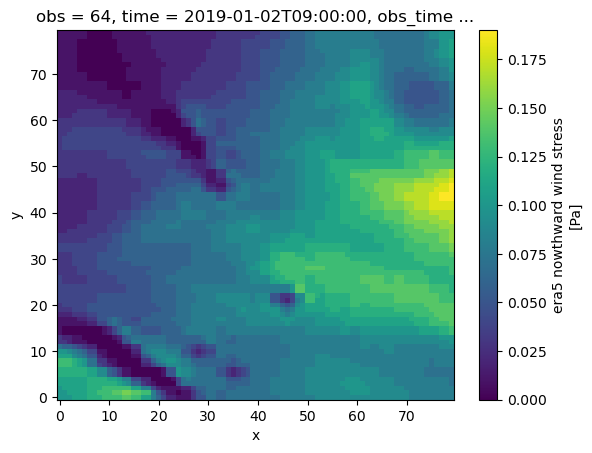

In [21]:
n_obs = 50
n_hour = 0
obs = res.isel(obs=n_obs)
obs.isel(t=n_hour).e5_tauv.plot()

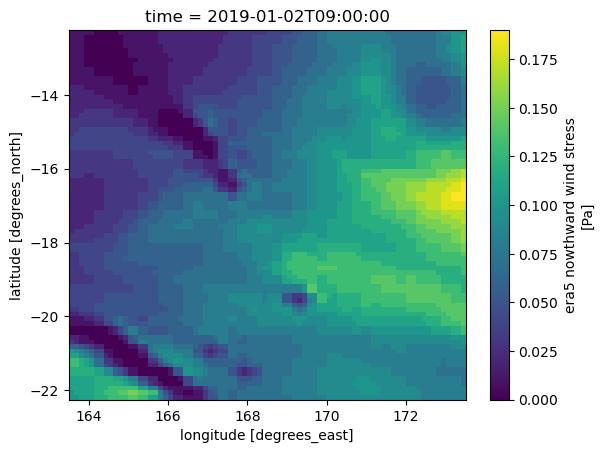

In [22]:
datacube.sel(
    time=obs.time.values[n_hour],
    lon=slice(obs.obs_lon.values-dlon, obs.obs_lon.values+dlon),
    lat=slice(obs.obs_lat.values-dlat, obs.obs_lat.values+dlat)
).e5_tauv.plot()

In [23]:
# Calculer la taille en mémoire de chaque variable
tailles_variables = {var: res[var].nbytes for var in res.variables}

# Calculer la taille totale du dataset
taille_totale = sum(tailles_variables.values())

print("Tailles des variables individuelles :")
for var, taille in tailles_variables.items():
    print(f"{var}: {taille} bytes")

print(f"Taille totale du dataset : {taille_totale} bytes")
print(f"Taille totale du dataset : {taille_totale / (1024 ** 3)} Go")

Tailles des variables individuelles :
e5_tauu: 1600000000 bytes
e5_tauv: 1600000000 bytes
es_tauu: 1600000000 bytes
es_tauv: 1600000000 bytes
obs: 20000 bytes
lat: 40000000 bytes
lon: 40000000 bytes
time: 500000 bytes
obs_time: 20000 bytes
obs_lat: 20000 bytes
obs_lon: 20000 bytes
Taille totale du dataset : 6480580000 bytes
Taille totale du dataset : 6.035510450601578 Go
